In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from datetime import date, timedelta
# data = pd.read_csv("inpatient_finalized_handoff/20220903_Counts_Products_Covid_Inpatient.dat.gz", header=None)
# data = data.rename(columns={0:'date', 1:'fips', 2:'count'})
# data['count'] = data['count'].replace({'3 or less':1})
# data['count'] = data['count'].astype(int)
# data = data[~data.fips.isna()]
# data.loc[:, 'fips'] = data.loc[:, 'fips'].astype(int).astype(str).str.zfill(5)
# data = data[(data.date > 20200801) & (data.date < 20220801)]
# data.loc[:, 'date'] = pd.to_datetime(data.date.astype(str))
# data = data.sort_values(by='date')
# data = data.groupby(['fips', 'date'])['count'].sum().reset_index()
# data_aug = (data.set_index('date').groupby('fips').resample('D').asfreq(0).drop(['fips'], axis=1).reset_index())
# data_aug.columns = ['geo_value', 'time_value', 'value']
# df_pivot = data_aug.pivot(index='time_value', columns='geo_value', values='value')
# df_pivot = df_pivot.dropna(axis=1, thresh=0.5 * len(df_pivot))
# df_pivot = df_pivot.fillna(0).astype(int)
# df_pivot.to_csv("CHNGclaim_county.csv")

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
hrr_map = pd.read_csv('geocorr2014.csv')
hrr_map['countystate'] = hrr_map['county'].apply(lambda x: x[:2])
hrr_map['hrrstate'] = hrr_map['hrrname'].apply(lambda x: x.split('-')[0].strip())
hrr_map['afact'] = pd.to_numeric(hrr_map['afact'], errors='coerce')
hrr_map['afact'] = hrr_map['afact'].map('{:.2f}'.format)
hrr_map = hrr_map[hrr_map['afact'] != '0.00']
hrr_map['afact'] = pd.to_numeric(hrr_map['afact'], errors='coerce')
hrr_map = hrr_map[hrr_map['afact'] >= 0.]

In [3]:
fips_to_state_abbrev = {
    '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', 
    '06': 'CA', '08': 'CO', '09': 'CT', '10': 'DE', 
    '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI', 
    '16': 'ID', '17': 'IL', '18': 'IN', '19': 'IA', 
    '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME', 
    '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', 
    '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', 
    '32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM', 
    '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH', 
    '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', 
    '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX', 
    '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA', 
    '54': 'WV', '55': 'WI', '56': 'WY', '60': 'AS', 
    '66': 'GU', '69': 'MP', '70': 'PW', '72': 'PR', 
    '78': 'VI'
}
data = pd.read_csv("CHNGclaim_county.csv", index_col=0)
print(data.index[688])

2022-06-21


In [4]:
data = pd.read_csv("CHNGclaim_county.csv", index_col=0).iloc[158:689]
data[data < 0] = 0
data = data.fillna(0).astype(int)
fips_prefixes = {col[:2] for col in data.columns}
fips_prefixes = np.sort(list(fips_prefixes))
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
date_seq = data.index
hrr_all = pd.DataFrame(index=date_seq)
for fips_prefix in fips_prefixes:
    state = fips_to_state_abbrev[fips_prefix]
    state_counties = [col for col in data.columns if col.startswith(fips_prefix)]
    state_data = data[state_counties]
    state_hrrs = np.unique([hrr for hrr in hrr_map.loc[hrr_map['hrrstate'] == state]['hrr']])
    if len(state_hrrs) > 0:
        hrr_aggregated = pd.DataFrame(index=date_seq)
        for hrr_code in state_hrrs:
            hrr_aggregated[hrr_code] = 0
            for index, row in hrr_map[hrr_map['hrr'] == hrr_code].iterrows():
                county = row['county']
                if county in data.columns:
                    allocation_factor = row['afact']
                    hrr_aggregated[hrr_code] += data[county] * allocation_factor
        hrr_all = pd.concat([hrr_all, hrr_aggregated], axis=1)
        np.round(hrr_aggregated, 2).to_csv(f'CHNGclaim/{state}_HRR.csv')
np.round(hrr_all, 2).to_csv(f'CHNGclaim/ALL_HRR.csv')
print(hrr_all.index[0], hrr_all.index[-1])

2021-01-07 00:00:00 2022-06-21 00:00:00


In [5]:
data = pd.read_csv("JHUcase_county.csv", index_col=0).iloc[281:812]
data[data < 0] = 0
data = data.fillna(0).astype(int)
fips_prefixes = {col[:2] for col in data.columns}
fips_prefixes = np.sort(list(fips_prefixes))
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
date_seq = data.index
hrr_all = pd.DataFrame(index=date_seq)
for fips_prefix in fips_prefixes:
    state = fips_to_state_abbrev[fips_prefix]
    state_counties = [col for col in data.columns if col.startswith(fips_prefix)]
    state_data = data[state_counties]
    state_hrrs = np.unique([hrr for hrr in hrr_map.loc[hrr_map['hrrstate'] == state]['hrr']])
    if len(state_hrrs) > 0:
        hrr_aggregated = pd.DataFrame(index=date_seq)
        for hrr_code in state_hrrs:
            hrr_aggregated[hrr_code] = 0
            for index, row in hrr_map[hrr_map['hrr'] == hrr_code].iterrows():
                county = row['county']
                if county in data.columns:
                    allocation_factor = row['afact']
                    hrr_aggregated[hrr_code] += data[county] * allocation_factor
        hrr_all = pd.concat([hrr_all, hrr_aggregated], axis=1)
        np.round(hrr_aggregated, 2).to_csv(f'JHUcase/{state}_HRR.csv')
np.round(hrr_all, 2).to_csv(f'JHUcase/ALL_HRR.csv')
print(hrr_all.index[0], hrr_all.index[-1])

2021-01-07 00:00:00 2022-06-21 00:00:00


In [6]:
data = pd.read_csv("CPRadmission_county.csv", index_col=0)
data[data < 0] = 0
data = data.fillna(0).astype(int)
fips_prefixes = {col[:2] for col in data.columns}
fips_prefixes = np.sort(list(fips_prefixes))
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
date_seq = data.index
hrr_all = pd.DataFrame(index=date_seq)
for fips_prefix in fips_prefixes:
    state = fips_to_state_abbrev[fips_prefix]
    state_counties = [col for col in data.columns if col.startswith(fips_prefix)]
    state_data = data[state_counties]
    state_hrrs = np.unique([hrr for hrr in hrr_map.loc[hrr_map['hrrstate'] == state]['hrr']])
    if len(state_hrrs) > 0:
        hrr_aggregated = pd.DataFrame(index=date_seq)
        for hrr_code in state_hrrs:
            hrr_aggregated[hrr_code] = 0
            for index, row in hrr_map[hrr_map['hrr'] == hrr_code].iterrows():
                county = row['county']
                if county in data.columns:
                    allocation_factor = row['afact']
                    hrr_aggregated[hrr_code] += data[county] * allocation_factor
        hrr_all = pd.concat([hrr_all, hrr_aggregated], axis=1)
        np.round(hrr_aggregated, 2).to_csv(f'CPRadmission/{state}_HRR.csv')
np.round(hrr_all, 2).to_csv(f'CPRadmission/ALL_HRR.csv')
print(hrr_all.index[0], hrr_all.index[-1])

2021-01-07 00:00:00 2022-06-21 00:00:00


In [7]:
data = pd.read_csv("QUIDELpositive_hrr.csv", index_col=0)
data.columns = data.columns.str.zfill(3)
data[data < 0] = 0
data = data.fillna(0)
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
date_seq = data.index
hrr_all = pd.DataFrame(index=date_seq)
for state in np.sort(hrr_map['hrrstate'].unique()):
    state_hrrs = np.unique([hrr for hrr in hrr_map.loc[hrr_map['hrrstate'] == state]['hrr']])
    state_hrrs = np.intersect1d(state_hrrs, data.columns)
    if len(state_hrrs) > 0:
        hrr_aggregated = pd.DataFrame(index=date_seq)
        for hrr_code in state_hrrs:
            hrr_aggregated[hrr_code] = data[hrr_code]
        hrr_all = pd.concat([hrr_all, hrr_aggregated], axis=1)
        hrr_aggregated.to_csv(f'QUIDELpositive/{state}_HRR.csv')
hrr_all.to_csv(f'QUIDELpositive/ALL_HRR.csv')
print(hrr_all.index[0], hrr_all.index[-1])

2020-08-01 00:00:00 2022-08-01 00:00:00


In [9]:
data = pd.read_csv("hrr-doctor-visits-smoothed_adj_cli-2020-08-01-to-2022-08-01.csv", dtype={'geo_value': str}, index_col=0)
data = data.pivot(index='time_value', columns='geo_value', values='value')
data.columns = data.columns.str.zfill(3)
data[data < 0] = 0
data = data.fillna(0)
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
date_seq = data.index
hrr_all = pd.DataFrame(index=date_seq)
for state in np.sort(hrr_map['hrrstate'].unique()):
    state_hrrs = np.unique([hrr for hrr in hrr_map.loc[hrr_map['hrrstate'] == state]['hrr']])
    state_hrrs = np.intersect1d(state_hrrs, data.columns)
    if len(state_hrrs) > 0:
        hrr_aggregated = pd.DataFrame(index=date_seq)
        for hrr_code in state_hrrs:
            hrr_aggregated[hrr_code] = data[hrr_code]
        hrr_all = pd.concat([hrr_all, hrr_aggregated], axis=1)
        hrr_aggregated.to_csv(f'doctorvisits/{state}_HRR.csv')
hrr_all.to_csv(f'doctorvisits/ALL_HRR.csv')
print(hrr_all.index[0], hrr_all.index[-1])

2020-08-01 00:00:00 2022-08-01 00:00:00


In [10]:
data = pd.read_csv("hrr-fb-survey-raw_whh_cmnty_cli-2020-08-01-to-2022-08-01.csv", dtype={'geo_value': str}, index_col=0)
data = data.pivot(index='time_value', columns='geo_value', values='value')
data.columns = data.columns.str.zfill(3)
data[data < 0] = 0
data = data.fillna(0)
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
date_seq = data.index
hrr_all = pd.DataFrame(index=date_seq)
for state in np.sort(hrr_map['hrrstate'].unique()):
    state_hrrs = np.unique([hrr for hrr in hrr_map.loc[hrr_map['hrrstate'] == state]['hrr']])
    state_hrrs = np.intersect1d(state_hrrs, data.columns)
    if len(state_hrrs) > 0:
        hrr_aggregated = pd.DataFrame(index=date_seq)
        for hrr_code in state_hrrs:
            hrr_aggregated[hrr_code] = data[hrr_code]
        hrr_all = pd.concat([hrr_all, hrr_aggregated], axis=1)
        hrr_aggregated.to_csv(f'FBwhh/{state}_HRR.csv')
hrr_all.to_csv(f'FBwhh/ALL_HRR.csv')
print(hrr_all.index[0], hrr_all.index[-1])

2020-08-01 00:00:00 2022-06-25 00:00:00


In [11]:
data = pd.read_csv("hrr-fb-survey-smoothed_wtested_14d-2020-08-01-to-2022-08-01.csv", dtype={'geo_value': str}, index_col=0)
data = data.pivot(index='time_value', columns='geo_value', values='value')
data.columns = data.columns.str.zfill(3)
data[data < 0] = 0
data = data.fillna(0)
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
date_seq = data.index
hrr_all = pd.DataFrame(index=date_seq)
for state in np.sort(hrr_map['hrrstate'].unique()):
    state_hrrs = np.unique([hrr for hrr in hrr_map.loc[hrr_map['hrrstate'] == state]['hrr']])
    state_hrrs = np.intersect1d(state_hrrs, data.columns)
    if len(state_hrrs) > 0:
        hrr_aggregated = pd.DataFrame(index=date_seq)
        for hrr_code in state_hrrs:
            hrr_aggregated[hrr_code] = data[hrr_code]
        hrr_all = pd.concat([hrr_all, hrr_aggregated], axis=1)
        hrr_aggregated.to_csv(f'FBwtested/{state}_HRR.csv')
hrr_all.to_csv(f'FBwtested/ALL_HRR.csv')
print(hrr_all.index[0], hrr_all.index[-1])

2020-09-08 00:00:00 2022-06-25 00:00:00


In [12]:
data = pd.read_csv("hrr-fb-survey-smoothed_wtested_positive_14d-2020-08-01-to-2022-08-01.csv", dtype={'geo_value': str}, index_col=0)
data = data.pivot(index='time_value', columns='geo_value', values='value')
data.columns = data.columns.str.zfill(3)
data[data < 0] = 0
data = data.fillna(0)
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
date_seq = data.index
hrr_all = pd.DataFrame(index=date_seq)
for state in np.sort(hrr_map['hrrstate'].unique()):
    state_hrrs = np.unique([hrr for hrr in hrr_map.loc[hrr_map['hrrstate'] == state]['hrr']])
    state_hrrs = np.intersect1d(state_hrrs, data.columns)
    if len(state_hrrs) > 0:
        hrr_aggregated = pd.DataFrame(index=date_seq)
        for hrr_code in state_hrrs:
            hrr_aggregated[hrr_code] = data[hrr_code]
        hrr_all = pd.concat([hrr_all, hrr_aggregated], axis=1)
        hrr_aggregated.to_csv(f'FBpositive/{state}_HRR.csv')
hrr_all.to_csv(f'FBpositive/ALL_HRR.csv')
print(hrr_all.index[0], hrr_all.index[-1])

2020-09-09 00:00:00 2022-06-25 00:00:00


In [13]:
data = pd.read_csv("hrr-fb-survey-raw_wcli-2020-08-01-to-2022-08-01.csv", dtype={'geo_value': str}, index_col=0)
data = data.pivot(index='time_value', columns='geo_value', values='value')
data.columns = data.columns.str.zfill(3)
data[data < 0] = 0
data = data.fillna(0)
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
date_seq = data.index
hrr_all = pd.DataFrame(index=date_seq)
for state in np.sort(hrr_map['hrrstate'].unique()):
    state_hrrs = np.unique([hrr for hrr in hrr_map.loc[hrr_map['hrrstate'] == state]['hrr']])
    state_hrrs = np.intersect1d(state_hrrs, data.columns)
    if len(state_hrrs) > 0:
        hrr_aggregated = pd.DataFrame(index=date_seq)
        for hrr_code in state_hrrs:
            hrr_aggregated[hrr_code] = data[hrr_code]
        hrr_all = pd.concat([hrr_all, hrr_aggregated], axis=1)
        hrr_aggregated.to_csv(f'FBwcli/{state}_HRR.csv')
hrr_all.to_csv(f'FBwcli/ALL_HRR.csv')
print(hrr_all.index[0], hrr_all.index[-1])

2020-08-01 00:00:00 2022-06-25 00:00:00


In [3]:
for i in range(1, 7):
    print(i)
    data = pd.read_csv(f"covidcast-google-symptoms-s0{i}_raw_search-2020-08-01-to-2022-08-01.csv", dtype={'geo_value': str}, index_col=0)
    data = data.pivot(index='time_value', columns='geo_value', values='value')
    data.columns = data.columns.str.zfill(3)
    data[data < 0] = 0
    data = data.fillna(0)
    data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
    date_seq = data.index
    hrr_all = pd.DataFrame(index=date_seq)
    for state in np.sort(hrr_map['hrrstate'].unique()):
        state_hrrs = np.unique([hrr for hrr in hrr_map.loc[hrr_map['hrrstate'] == state]['hrr']])
        state_hrrs = np.intersect1d(state_hrrs, data.columns)
        if len(state_hrrs) > 0:
            hrr_aggregated = pd.DataFrame(index=date_seq)
            for hrr_code in state_hrrs:
                hrr_aggregated[hrr_code] = data[hrr_code]
            hrr_all = pd.concat([hrr_all, hrr_aggregated], axis=1)
            hrr_aggregated.to_csv(f'GoogleS0{i}/{state}_HRR.csv')
    hrr_all.to_csv(f'GoogleS0{i}/ALL_HRR.csv')
    print(hrr_all.index[0], hrr_all.index[-1])

1
2020-08-01 00:00:00 2022-08-01 00:00:00
2
2020-08-01 00:00:00 2022-08-01 00:00:00
3
2020-08-01 00:00:00 2022-08-01 00:00:00
4
2020-08-01 00:00:00 2022-08-01 00:00:00
5
2020-08-01 00:00:00 2022-08-01 00:00:00
6
2020-08-01 00:00:00 2022-08-01 00:00:00


In [1]:
!pip install covidcast

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for covidcast from https://files.pythonhosted.org/packages/5c/5f/5fa7a3d1302051d061d2041f0fba2722a09d62e629c705b3a0a6ec214d2b/covidcast-0.2.2-py3-none-any.whl.metadata
  Obtaining dependency information for pandas<2 from https://files.pythonhosted.org/packages/56/73/3351beeb807dca69fcc3c4966bcccc51552bd01549a9b13c04ab00a43f21/pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for delphi-epidata==4.*,>=4.1.11 from https://files.pythonhosted.org/packages/43/8c/c21676a23fcd82c464148dfedd44a96e1cb7c9e68c6d3e302354caf69166/delphi_epidata-4.1.25-py3-none-any.whl.metadata
  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/0b/70/d5cd0696eff08e62fdbdebe5b46527facb4e7220eabe0ac6225efab50168/geopandas-1.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for descarte

In [1]:
import pandas as pd
from datetime import date, timedelta
from covidcast import covidcast
covidcast.use_api_key('cd916f2b0846b')

all_data = covidcast.signal("dsew-cpr", "confirmed_admissions_covid_1d_7dav",
                            date(2021, 1, 7), date(2022, 6, 21),
                            "nation")
all_data = all_data.pivot(index='time_value', columns='geo_value', values='value')
all_data.columns = ['CPRadmission']
JHUcase = pd.read_csv('JHUcase_county.csv', index_col=0).sum(axis=1).loc['2021-01-07':'2022-06-21']
JHUcase.index = pd.to_datetime(JHUcase.index)
CHNGclaim = pd.read_csv('CHNGclaim_county.csv', index_col=0).sum(axis=1).loc['2021-01-07':'2022-06-21']
CHNGclaim.index = pd.to_datetime(CHNGclaim.index)
all_data['JHUcase'] = JHUcase
all_data['CHNGclaim'] = CHNGclaim

data = covidcast.signal("fb-survey", "raw_whh_cmnty_cli",
                            date(2021, 1, 7), date(2022, 6, 21),
                            "nation")
data = data.pivot(index='time_value', columns='geo_value', values='value')
data.columns = ['FBwhh']
all_data['FBwhh'] = data['FBwhh']

data = covidcast.signal("fb-survey", "smoothed_wtested_14d",
                            date(2021, 1, 7), date(2022, 6, 21),
                            "nation")
data = data.pivot(index='time_value', columns='geo_value', values='value')
data.columns = ['FBwtested']
all_data['FBwtested'] = data['FBwtested']

data = covidcast.signal("fb-survey", "smoothed_wtested_positive_14d",
                            date(2021, 1, 7), date(2022, 6, 21),
                            "nation")
data = data.pivot(index='time_value', columns='geo_value', values='value')
data.columns = ['FBpositive']
all_data['FBpositive'] = data['FBpositive']

data = covidcast.signal("doctor-visits", "smoothed_adj_cli",
                            date(2021, 1, 7), date(2022, 6, 21),
                            "nation")
data = data.pivot(index='time_value', columns='geo_value', values='value')
data.columns = ['doctorvisits']
all_data['doctorvisits'] = data['doctorvisits']

data = covidcast.signal("quidel", "covid_ag_raw_pct_positive",
                            date(2021, 1, 7), date(2022, 6, 21),
                            "nation")
data = data.pivot(index='time_value', columns='geo_value', values='value')
data.columns = ['QUIDELpositive']
all_data['QUIDELpositive'] = data['QUIDELpositive']

data = covidcast.signal("fb-survey", "raw_wcli",
                        date(2021, 1, 7), date(2022, 6, 21),
                        "nation")
data = data.pivot(index='time_value', columns='geo_value', values='value')
data.columns = ['FBwcli']
all_data['FBwcli'] = data['FBwcli']

all_data

,CPRadmission,JHUcase,CHNGclaim,FBwhh,FBwtested,FBpositive,doctorvisits,QUIDELpositive,FBwcli
time_value,,,,,,,,,
2021-01-07,15964.714286,284945.0,5998,32.742633,13.925331,20.908668,11.855563,14.187168,1.386376
2021-01-08,15866.714286,302549.0,6220,32.614801,14.011955,21.103981,11.003106,13.602430,1.479027
2021-01-09,15803.714286,263435.0,4965,32.847159,14.175705,21.282342,10.272835,14.830724,1.324796
2021-01-10,15935.714286,209944.0,4434,32.423110,14.345898,21.592634,9.812892,15.370420,1.280667
2021-01-11,16031.714286,204391.0,6123,32.109281,14.473354,21.692202,9.656931,13.199533,1.260960
...,...,...,...,...,...,...,...,...,...
2022-06-17,4307.285714,138809.0,728,26.292882,23.261335,27.713614,2.330213,16.818444,2.832629
2022-06-18,4300.357143,17788.0,570,26.201770,23.280891,27.989154,2.401378,24.478676,3.329621
2022-06-19,4293.428571,18150.0,564,25.781329,23.397018,28.594993,2.458159,27.004034,3.167238


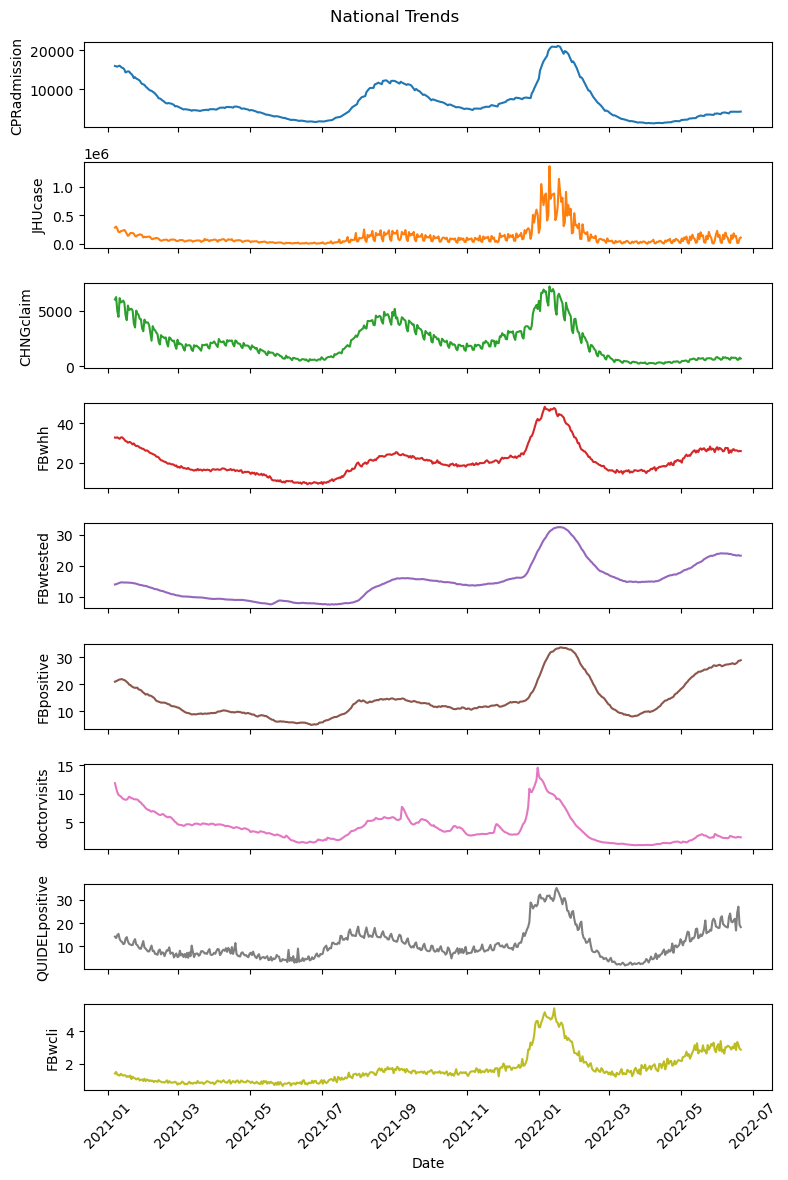

In [2]:
import matplotlib.pyplot as plt
all_data.to_csv('all_data.csv')
columns = [
    "CPRadmission", "JHUcase", "CHNGclaim", "FBwhh", "FBwtested", 
    "FBpositive", "doctorvisits", "QUIDELpositive", "FBwcli"
]

# Create subplots
fig, axes = plt.subplots(9, 1, figsize=(8, 12), sharex=True)

# Plot each variable in a separate subplot
for i, col in enumerate(columns):
    axes[i].plot(all_data.index, all_data[col], label=col, color='C'+str(i))
    axes[i].set_ylabel(col)

# Formatting
axes[-1].set_xlabel("Date")
fig.suptitle("National Trends")
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig('all_signals.png')